In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [2]:
# data_df = pd.read_csv("low_503.csv")
# data_df = pd.read_csv('pca_Q1_173.csv')

data_df = pd.read_csv('ori_729.csv')

In [3]:
data_df.drop(labels='pIC50',inplace=True,axis=1)##删掉这玩意
data_df_y = data_df['IC50_nM']
data_df_x = data_df.drop(labels=['SMILES','IC50_nM'],axis=1)
data_df_x.shape
X,y = data_df_x , data_df_y
xlist = X.columns

In [4]:
from sklearn.metrics import r2_score,mean_squared_error

def evaluate(data,model):
    pre = model.predict(data)
    pre_res = [round(res) for res in pre]
    y = data.get_label()
    acc = r2_score(y,pre_res)
    return acc
#先定义评价函数
def print_r2_score(model,x_train,y_train,x_test,y_test):
    print(model.score(x_train,y_train))
    print(model.score(x_test,y_test))

In [5]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
#标准化 0.79
#非标准化 0.80

# std1 = MinMaxScaler()
# X=std1.fit_transform(X)
# std2 = MinMaxScaler()
# y=std2.fit_transform(y.values.reshape(-1,1))
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=666)
std1 = MinMaxScaler()
X_std =std1.fit_transform(X)
std2 = MinMaxScaler()
y_std =std2.fit_transform(y.values.reshape(-1,1))

In [20]:
# 1.3 写一个function 返回sklearn中 特征重要性排名和分数 的 dataframe
def get_classifer_ranked_feature(clf,feature_names):
    name_im = pd.DataFrame({'var':feature_names,'importance':clf.feature_importances_*100})
    name_im = name_im.sort_values(by='importance',ascending=False)
    return name_im

# xgboost

In [21]:
%%time
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor as XGBR

from sklearn.model_selection import KFold, cross_val_score as CVS
 

#1.sklearn实现法 不方便花 学习曲线
xgbr = XGBR(n_estimators=300,max_depth=8, n_jobs=-1,learning_rate=0.15)
xgbr.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='rmse',
        verbose=False)
evals_result = xgbr.evals_result()#fit中有eval_metric
plot_importance(xgbr,max_num_features=20,importance_type='gain')


Wall time: 15 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

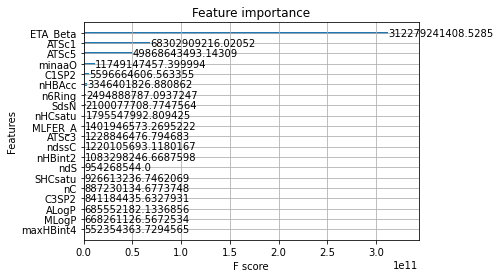

In [22]:
plot_importance(xgbr,max_num_features=20,importance_type='gain')

## random forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

RandomForestRegressor()

## lightgbm

In [24]:
from lightgbm import LGBMRegressor

#最好是2和3
lgbm = LGBMRegressor(n_estimators=300,max_depth=3,learning_rate=0.15)
lgbm.fit(x_train, y_train
        , eval_set=[(x_test, y_test)]
        , eval_metric='rmse',verbose=30)

C:\Users\wtf\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	valid_0's rmse: 64946.5	valid_0's l2: 4.21805e+09
[60]	valid_0's rmse: 76747.8	valid_0's l2: 5.89022e+09
[90]	valid_0's rmse: 89343.6	valid_0's l2: 7.98228e+09
[120]	valid_0's rmse: 88557.1	valid_0's l2: 7.84236e+09
[150]	valid_0's rmse: 87663.2	valid_0's l2: 7.68484e+09
[180]	valid_0's rmse: 86451.4	valid_0's l2: 7.47384e+09
[210]	valid_0's rmse: 84824.8	valid_0's l2: 7.19525e+09
[240]	valid_0's rmse: 85983.6	valid_0's l2: 7.39318e+09
[270]	valid_0's rmse: 84756.5	valid_0's l2: 7.18366e+09
[300]	valid_0's rmse: 85727.2	valid_0's l2: 7.34915e+09


LGBMRegressor(learning_rate=0.15, max_depth=3, n_estimators=300)

In [25]:
print_r2_score(rfr,x_train,y_train,x_test,y_test)
print('----------------------------------')
print_r2_score(xgbr,x_train,y_train,x_test,y_test)
print('----------------------------------')
print_r2_score(lgbm,x_train,y_train,x_test,y_test)

0.8150694377175455
0.5395858963596646
----------------------------------
0.9999541101632689
0.8059146594521258
----------------------------------
0.9709574957929151
-3.0527023269608318


## 通过特征重要性来筛选，生成 特征重要性表格

In [26]:
xgbr_fea = get_classifer_ranked_feature(xgbr,xlist)
rfr_fea = get_classifer_ranked_feature(rfr,xlist)
lgbm_fea = get_classifer_ranked_feature(lgbm,xlist)

In [28]:

#
xgbr_fea.to_csv('xgbr_fea_sel.csv',index=False)

In [41]:
rfr_fea.head(20)
#rfr_fea.to_csv('rfr_fea_sel.csv',index=False)
lgbm_fea.to_csv('lgbm_fea_sel.csv',index=False)

In [17]:
#list(lgbm_fea['var'])[0:40]

In [33]:
list(xgbr_fea['var'])[0:5]

['ETA_Beta', 'ATSc1', 'ATSc5', 'minaaO', 'C1SP2']

In [35]:
list(rfr_fea['var'])[0:14]

['ETA_Beta',
 'ATSc5',
 'ETA_EtaP_B_RC',
 'ETA_EtaP_B',
 'ECCEN',
 'ETA_BetaP',
 'maxaaO',
 'minaaO',
 'mindssC',
 'ATSc2',
 'nHBAcc_Lipinski',
 'C2SP2',
 'nTG12Ring',
 'ATSp4']

In [36]:
a = ['ETA_Beta', 'ATSc1', 'ATSc5', 'minaaO', 'C1SP2']
b = ['ETA_Beta',
 'ATSc5',
 'ETA_EtaP_B_RC',
 'ETA_EtaP_B',
 'ECCEN',
 'ETA_BetaP',
 'maxaaO',
 'minaaO',
 'mindssC',
 'ATSc2',
 'nHBAcc_Lipinski',
 'C2SP2',
 'nTG12Ring',
 'ATSp4']
c=(set(a) | set(b))

In [37]:
c

{'ATSc1',
 'ATSc2',
 'ATSc5',
 'ATSp4',
 'C1SP2',
 'C2SP2',
 'ECCEN',
 'ETA_Beta',
 'ETA_BetaP',
 'ETA_EtaP_B',
 'ETA_EtaP_B_RC',
 'maxaaO',
 'minaaO',
 'mindssC',
 'nHBAcc_Lipinski',
 'nTG12Ring'}

In [38]:
new_label = list(c)

In [39]:
new_label

['ETA_Beta',
 'ETA_EtaP_B_RC',
 'nHBAcc_Lipinski',
 'ETA_BetaP',
 'C2SP2',
 'ATSc5',
 'maxaaO',
 'ATSc1',
 'C1SP2',
 'ECCEN',
 'mindssC',
 'ATSc2',
 'ETA_EtaP_B',
 'minaaO',
 'nTG12Ring',
 'ATSp4']